# Modules

In [1]:
import numpy as np
import pandas as pd
import warnings
import datetime
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Fonctions

In [2]:
def customize_corr(df: pd.DataFrame) :
    
    """ 
      Customize correlation matrix visually  
      
    Arguments:
        df - dataframe with features
    
    Returns: 
    """
    
    # modules
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(16, 10))
    
    # define the mask to set the values in the upper triangle to True
    mask = np.triu(np.ones_like(df.corr()))
    heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='magma')
    heatmap.set_title('Lower Correlation Matrix', fontdict={'fontsize':18}, pad=16)

In [3]:
def corr_features(df: pd.DataFrame, threshold: float) :
    
    """  
      A function to suggest features that are highly correlated (one among two). 
            
      Arguments:
          df - dataframe with features
          treshold - lower limit to consider that features are not highly correlated
    
    Returns:  
        List of features to drop
    """
    
    correlation = df.corr().abs()
    upper = correlation .where(np.triu(np.ones(correlation .shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    return to_drop

In [4]:
df = pd.read_pickle('intermed/table_fo_lifetime.sav')
df.set_index('customer_Id', inplace=True)
df.head()

,Gender,tran_date,category_Bags,category_Books,category_Clothing,category_Electronics,category_Footwear,category_Home and kitchen,frequency,recency,...,R,F,M,RFM_Segment,Score,RFM_Score,Segment,age,life,attrition
customer_Id,,,,,,,,,,,,,,,,,,,,,
266783,M,2013-02-20,0,1,1,0,1,0,3.0,516.0,...,2,2,1,221,Green,5,Hibernating,47,12,0
266784,F,2012-12-04,0,1,0,1,0,0,2.0,103.0,...,1,2,1,121,Green,4,Hibernating,30,23,1
266785,F,2013-08-01,1,1,0,0,1,1,6.0,870.0,...,4,4,4,444,Platinum,12,Champions,36,11,0
266788,F,2013-02-12,1,1,0,0,1,0,3.0,611.0,...,2,2,2,222,Bronze,6,Hibernating,49,12,0
266794,F,2014-02-12,1,1,1,1,1,0,9.0,1062.0,...,4,4,3,443,Platinum,11,Champions,50,0,0


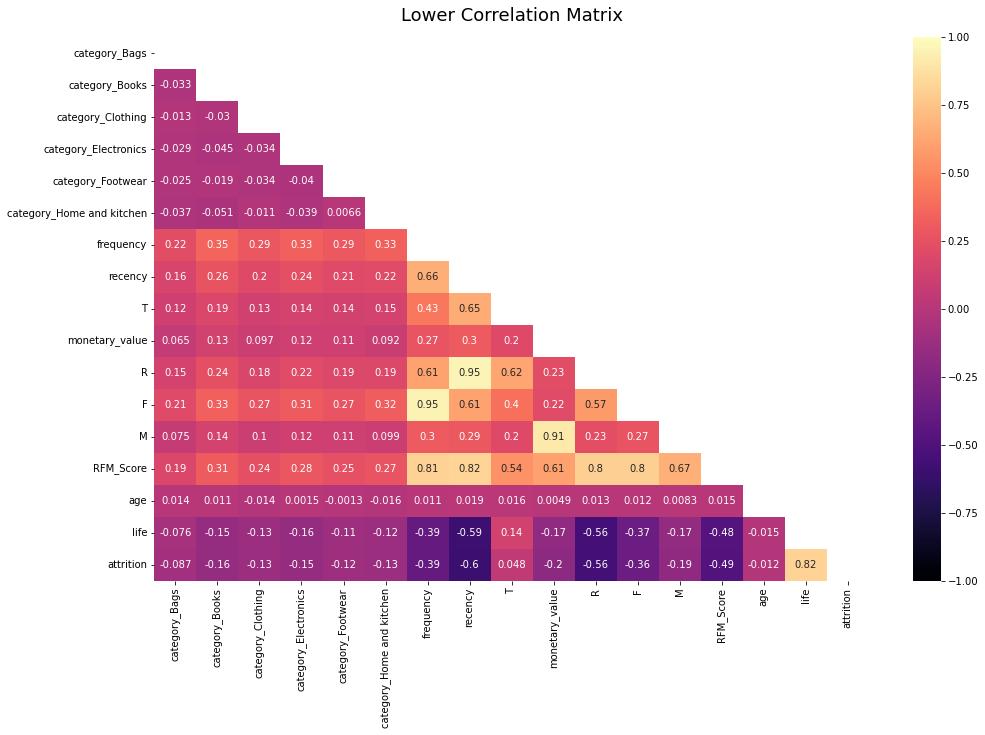

In [5]:
customize_corr(df)

In [6]:
corr_features(df, 0.9)

['R', 'F', 'M']

In [45]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter
from lifelines import  KaplanMeierFitter
from lifelines import  NelsonAalenFitter

Nous ne disposons pas de la fonction de survie théorique de la clientèle.

Nous allons l'estimer à partir des données :  l'estimateur non paramétrique de Kaplan-Meier

$$S(t)=\prod_{\substack{i= t_i \le t}}\frac{n_i-d_i}{n_i}$$ 

$n_i$ = population à risque au moment juste avant le temps $t_i$

$d_i$ = nombre d'événements survenus à l'instant $ t_i $

In [14]:
kmf = KaplanMeierFitter()
kmf.fit(durations=df.life, event_observed=df.attrition, label="KM estimate")

<lifelines.KaplanMeierFitter:"KM estimate", fitted with 5506 total observations, 4144 right-censored observations>

Les clients  qui n'ont pas été soumis à l'événement de décès d'attrition sont étiquetés comme censurés à droite,

c'est-à-dire que nous n'avons pas (ou ne pouvons pas) voir le reste de leur histoire de vie en raison de certaines circonstances externes (ici la fin de l'expérimenttion s'arrete en  Fevrier 2014)

Text(0.5, 1.0, 'Fonctions de survie de la clientèles')

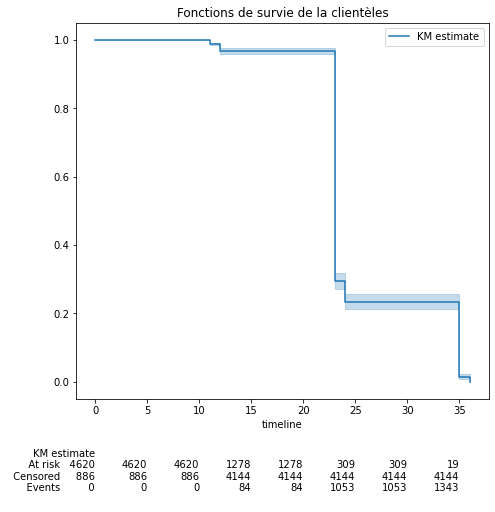

In [35]:
kmf.plot_survival_function(figsize=(7, 7), at_risk_counts=True)
plt.title('Fonctions de survie de la clientèles')

L'axe des ordonnées représente la probabilité qu'un client soit notre client après t mois , où t mois se lit en abscisses.

In [10]:
kmf.median_survival_time_

23.0

Nos clients ont 50 % de chances de partir  après 23 mois ou moins !

In [11]:
from lifelines.utils import median_survival_times
median_survival_times(kmf.confidence_interval_)

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.5,23.0,23.0


Text(0.5, 1.0, 'Fonctions de survie selon le sexe')

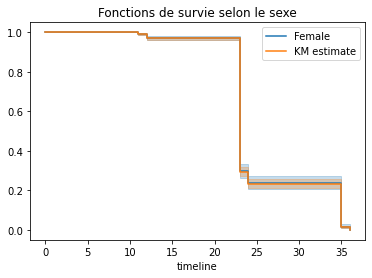

In [33]:
ax = plt.subplot(111)

kmf_gender = KaplanMeierFitter()



kmf_gender.fit(
              durations = df[df['Gender'] == 'F']['life'], 
              event_observed=df[df['Gender'] == 'F']['attrition'],
              label='Female'
               )
kmf_gender.plot_survival_function(ax=ax)

kmf_gender.fit(
              durations = df[df['Gender'] == 'M']['life'], 
              event_observed=df[df['Gender'] == 'M']['attrition'],
              label='MALE'
               )

kmf.plot_survival_function(ax=ax)

plt.title('Fonctions de survie selon le sexe')

Il n y a pas de difference significrative selon le genre.

Néanmoins, l'expérience à montrer l'approche KM ne permet pas de bien estimer les fonctions de risques( hazard function) et  fonction cumulées de risque

$$\tilde H(t)=\sum_{\substack{i= t_i < t}}\frac{d_i}{n_i}$$ 

$n_i$ = population à risque au moment juste avant le temps $t_i$

$d_i$ = nombre d'événements survenus à l'instant $ t_i $

Cet estimateur présente des avantages par rapport à l'estimateur de Kaplan-Meier.

L'estimateur donne le nombre d'événements attendu correct.
Il existe une multitude de théories asymptotiques basées sur l'estimateur d'Altschuler-Nelson.

$$S(t) =exp(\tilde H(t) )$$ 


<AxesSubplot:xlabel='timeline'>

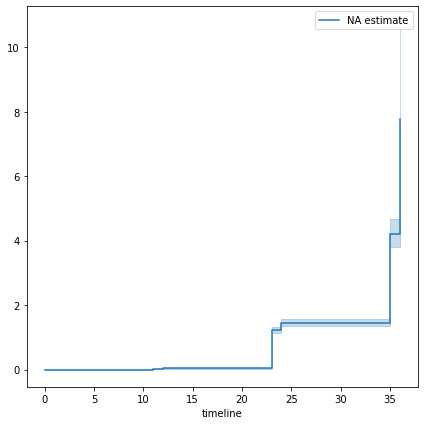

In [49]:
naf = NelsonAalenFitter()
naf.fit(durations=df.life, event_observed=df.attrition, label="NA estimate")
naf.plot_cumulative_hazard(figsize=(7,7))

L'interprétation de la fonction de risque cumulé peut être difficile - ce n'est pas la façon dont nous interprétons habituellement les fonctions. D'autre part, la plupart des analyses de survie sont effectuées à l'aide de la fonction de risque cumulé, il est donc recommandé de la comprendre.

Néanmoins nous pouvons déduire  la fonction de risque qui est plus interpretable. Mais il y a un hic. La déduction implique un lissage du noyau (pour lisser les différences de la fonction de risque cumulé), et cela nous oblige à spécifier un paramètre de bande passante qui contrôle de bandwith.

<AxesSubplot:>

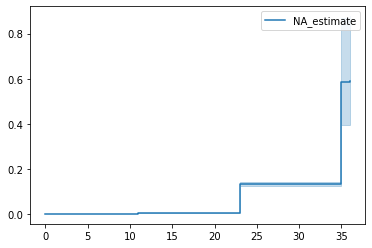

In [79]:
naf = NelsonAalenFitter()
naf.fit(durations=df.life, event_observed=df.attrition)
naf.plot_hazard(bandwidth=8)